# Интеллектуальный анализ данных – весна 2022

# Домашнее задание 7: Деревья. Случайный лес

Правила:

- Домашнее задание оценивается в 10 баллов (+1 бонусный балл).


- Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.


- Можно использовать любые свободные источники с обязательным указанием ссылки на них.


- Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

<!-- ![](meme.jpg) -->
<img src="meme.jpg" alt="Drawing" style="width: 700px;"/>

## Часть 1: Основы построения решающие дерева (1.5 балла)

В этой части все расчёты необходимо реализовывать в виде запрограммированных формул, например, на `numpy`. **Нельзя использовать готовые реализации**. Например, если в задании требуется рассчитать энтропию, то требуется в каком-то виде релизовать расчёт по формуле, но нельзя использовать готовую реализацию `some_module.entropy()`.

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Задание 1.1 (0.5 балла)** Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$. Рассчитайте энтропию такого распределения классов (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

In [8]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(=====>

def count_entropy(classes: list) -> float:
    num_elements = 0
    num_classes = len(classes)
    for i in range(num_classes):
        num_elements += classes[i]
    p = [i / num_elements for i in classes]
    entropy = 0
    for i in range(num_classes):
        entropy -= (p[i] * np.log(p[i]))
    return entropy
        
classes = [8, 2]
entropy = count_entropy(classes)
entropy = round(entropy, 2)
entropy

0.5

**Задание 1.2 (0.5 балла)** Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

Теперь в качестве $H(R)$ будем использовать индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов (в нашем случае, $J = 2$).

Ответ округлите до двух знаков после запятой.

In [9]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
def gini(classes: list) -> float:
    num_elements = 0
    num_classes = len(classes)
    for i in range(num_classes):
        num_elements += classes[i]
    p = [i / num_elements for i in classes]
    jini = 0
    for i in range(num_classes):
        jini += p[i] * (1 - p[i])
    return jini

In [10]:
def information_crit(Rm: list, left: list, right: list) -> float:
    H_Rm = gini(Rm)
    H_Rl = gini(left)
    H_Rr = gini(right)

    left_sum = 0
    right_sum = 0
    all_sum = 0

    for i in range(len(left)):
        left_sum += left[i]

    for i in range(len(right)):
        right_sum += right[i]

    all_sum = left_sum + right_sum

    left_ratio = left_sum / all_sum
    right_ratio = right_sum / all_sum

    # calculating the IGR:
    info_crit = H_Rm - left_ratio * H_Rl - right_ratio * H_Rr

    return info_crit

In [11]:
Rm = [8, 2]
Rl = [8, 0]
Rr = [0, 2]

information_crit(Rm, Rl, Rr)

0.32

**Задание 1.3 (0.5 балла)** Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

In [12]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
target_values = [1, 10, 5, 18, 100, 30, 50, 61, 84, 47]
predictions = sum(target_values) / len(target_values)

print(predictions)

40.6


## Часть 2: Решающие деревья (4.5 балла)

В этой части мы напишем и протестируем собственную реализацию решающего дерева.

In [13]:
from collections import Counter
from typing import Dict, List, Tuple, Union

**Задание 2.1 (1.5 балла)** Реализуйте функцию `find_best_split()`, которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием из **Задания 1.2**. В качестве меры хаотичности $H(R)$ для задачи регрессии испольуйте дисперсию подвыборки, а для задачи классификации – критерий Джини (определён в том же задании).

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям.

**Бонус:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла – **бонус 1 балл**.

In [224]:
def gini(target_vector: Union[np.ndarray, pd.Series]) -> float:
    classes, counts = np.unique(target_vector, return_counts=True)
    probability = counts / len(target_vector)
    gini = np.sum(probability * (1 - probability))
    
    return gini

In [ ]:
def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame], 
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух сосдених (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини или дисперсии нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)
    :param task: либо `classification`, либо `regression`
    :param feature_type: либо `real`, либо `categorical`
    
    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return info_crits: вектор со значениями критерия информативности для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return info_crits_best: оптимальное значение критерия информативности (число)
    """
    indices = np.argsort(feature_vector)
    sorted_feature = feature_vector[indices]
    sorted_target = target_vector[indices]
    thresholds = (sorted_feature[:-1] + sorted_feature[1:]) / 2

    if task == 'classification':
        info_crits = list(
            (gini(sorted_target[:i]) * i + gini(sorted_target[i:]) * (len(sorted_target) - i)) / len(sorted_target)
            for i in np.searchsorted(sorted_feature, thresholds, side='right')
        )
    else:
        info_crits = list(
            (np.var(sorted_target[:i]) * i + np.var(sorted_target[i:]) * (len(sorted_target) - i)) / len(sorted_target)
            for i in np.searchsorted(sorted_feature, thresholds, side='right')
        )

    min_info_crit = np.min(info_crits)
    min_info_crit_indices = np.where(info_crits == min_info_crit)[0] 
    thresholds_with_min_info_crit = thresholds[min_info_crit_indices]
    threshold_best = np.min(thresholds_with_min_info_crit)

    return thresholds, np.array(info_crits), threshold_best, min_info_crit


Эту функцию можно протестировать на датасете `California`.

In [294]:
from sklearn.datasets import fetch_california_housing

In [295]:
data = fetch_california_housing()
X = pd.DataFrame(data=data["data"], columns=data["feature_names"])
y = data["target"]
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [296]:
y

array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894])

Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `MedInc`.

In [297]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
%matplotlib inline

thresholds, info_crits, threshold_best, info_crits_best = find_best_split(X['MedInc'].values, y)

print(thresholds, info_crits, threshold_best, info_crits_best)
info_crits

[ 0.4999  0.4999  0.4999 ... 15.0001 15.0001 15.0001] [0.99718158 0.99718158 0.99718158 ... 0.99723626 0.99723626 0.99723626] 7.81515 0.9847476488023436


array([0.99718158, 0.99718158, 0.99718158, ..., 0.99723626, 0.99723626,
       0.99723626])

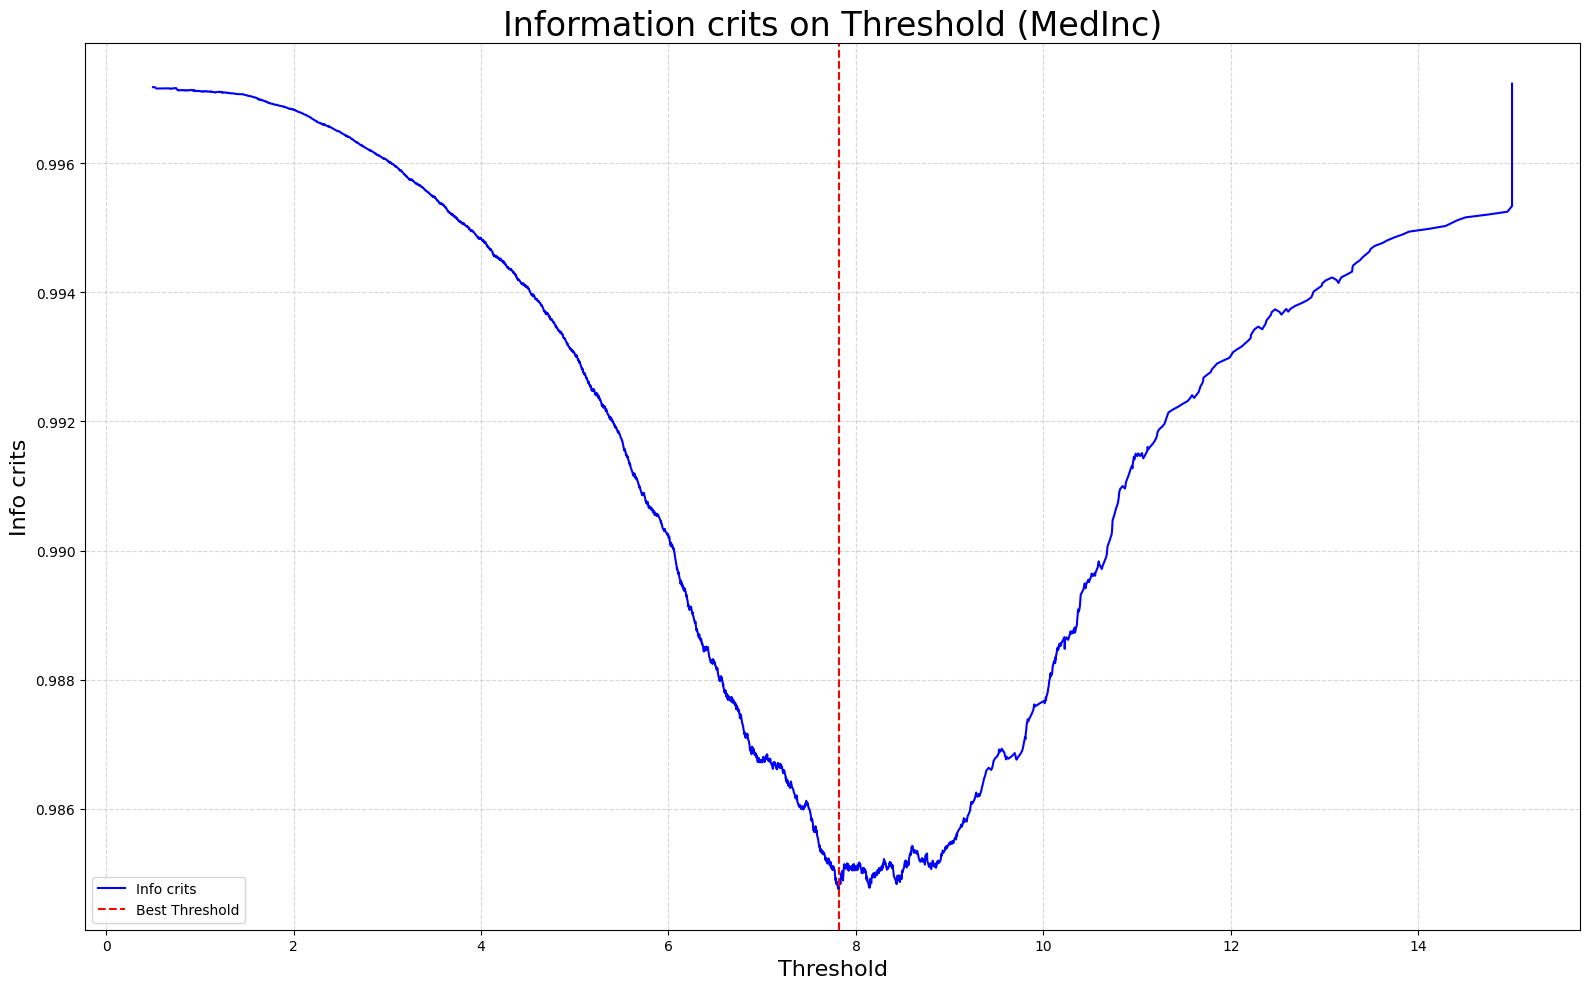

In [298]:
fig, ax = plt.subplots(figsize=(16, 10))
ax.plot(thresholds, info_crits, color='b', label='Info crits')
ax.axvline(x=threshold_best, color='r', linestyle='--', label='Best Threshold')


ax.set_xlabel('Threshold', fontsize=16)
ax.set_ylabel('Info crits', fontsize=16)
ax.set_title('Information crits on Threshold (MedInc)', fontsize=24)
ax.grid(True, linestyle='--', alpha=0.5)
ax.legend()
plt.tight_layout()

plt.show()

Найдите лучший, с вашей точки зрения, предикат первой вершины решающего дерева.

In [332]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
best_predicate = ""
best_threshold = 0
best_info_crit = 0

for feature in X.columns:
    thresholds, criterion_values, threshold_best, info_crits_best = find_best_split(X[feature].values, y)

    if best_info_crit == 0 or info_crits_best < best_info_crit:
        best_info_crit = info_crits_best
        best_predicate = feature
        best_threshold = threshold_best

print("best predicate:", best_predicate)
print("best criterion:", best_info_crit)
print("best threshold:", best_threshold)

best predicate: MedInc
best criterion: 0.9847476488023436
best threshold: 7.81515


**Задание 2.2 (1 балл)** Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод `_predict_node()`.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- **Выбор лучшего разбиения** необходимо производить по критерию Джини.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.

В задаче также предлагается получить два бонуса, по баллу на каждый!

- **Реализуйте способ обрабатывать пропуски в даннх и реализуйте его, пояснив свои действия.**
- **Реализуйте метод оценки важности признаков.**

In [333]:
class DecisionTree:
    
    def __init__(
        self, 
        feature_types: Union[List[str], np.ndarray], 
        max_depth: int = None, 
        min_samples_split: int = None, 
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:
        
        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        # В этой переменной будем хранить узлы решающего дерева. Каждая вершина хранит в себе идентификатор того,
        # является ли она листовой. Листовые вершины хранят значение класса для предсказания, нелистовые - правого и
        # левого детей (поддеревья для продолжения процедуры предсказания)
        self._tree = {}
        
        # типы признаков (категориальные или числовые)
        self._feature_types = feature_types
        
        # гиперпараметры дерева
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task
        
        # Переменная, если вы решите делать бонус
        self._feature_importances = {}
        

    def _fit_node(
        self, 
        sub_X: np.ndarray, 
        sub_y: np.ndarray, 
        node: dict
    ) -> None:
        
        # критерий останова
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            categories_map = {}

            # подготавливаем признак для поиска оптимального порога
            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                # здесь могла быть реализация более сложного подхода к обработке категориального признака
                feature_vector = sub_X[:, feature]

            # ищем оптимальный порог
            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task, feature_type)
            
            if gini_best is None or gini > gini_best:
                feature_best = feature
                gini_best = gini

                # split - маска на объекты, которые должны попасть в левое поддерево
                if feature_type == "real":
                    threshold_best = threshold
                    split = feature_vector <= threshold_best
                elif feature_type == "categorical":
                    # в данной реализации это просто значение категории
                    threshold_best = threshold
                    split = feature_vector == threshold_best
                else:
                    raise ValueError

        # записываем полученные сплиты в атрибуты класса
        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError
            
        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"])

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        """
        Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево в зависимости от значения
        предиката на объекте. Листовая вершина возвращает предсказание.
        :param x: np.array, элемент выборки
        :param node: dict, вершина дерева
        """
        # ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
        if node["type"] == "terminal":
            return node["class"]
    
        feature_split = node["feature_split"]
        if self._feature_types[feature_split] == "real":
            threshold = node["threshold"]
            if x[feature_split] <= threshold:
                return self._predict_node(x, node["left_child"])
            else:
                return self._predict_node(x, node["right_child"])
    
        elif self._feature_types[feature_split] == "categorical":
            category_split = node["category_split"]
            if x[feature_split] == category_split:
                return self._predict_node(x, node["left_child"])
            else:
                return self._predict_node(x, node["right_child"])

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self._fit_node(X, y, self._tree)

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))
            
        return np.array(predicted)

**Задание 2.3 (1 балл)** Загрузите таблицу `students.csv` (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте диаграммы рассеяния "значение признака — класс" для всех пяти признаков.

In [334]:
df = pd.read_csv(r'C:\Users\Oleg\Desktop\students.csv')
df

,Unnamed: 0,STG,SCG,STR,LPR,PEG,UNS
0,0,0.00,0.00,0.00,0.00,0.00,0
1,1,0.08,0.08,0.10,0.24,0.90,1
2,2,0.06,0.06,0.05,0.25,0.33,0
3,3,0.10,0.10,0.15,0.65,0.30,1
4,4,0.08,0.08,0.08,0.98,0.24,0
...,...,...,...,...,...,...,...
253,253,0.61,0.78,0.69,0.92,0.58,1
254,254,0.78,0.61,0.71,0.19,0.60,1
255,255,0.54,0.82,0.71,0.29,0.77,1
256,256,0.50,0.75,0.81,0.61,0.26,1


In [335]:
df.drop(columns = ["Unnamed: 0"], inplace = True )
df

,STG,SCG,STR,LPR,PEG,UNS
0,0.00,0.00,0.00,0.00,0.00,0
1,0.08,0.08,0.10,0.24,0.90,1
2,0.06,0.06,0.05,0.25,0.33,0
3,0.10,0.10,0.15,0.65,0.30,1
4,0.08,0.08,0.08,0.98,0.24,0
...,...,...,...,...,...,...
253,0.61,0.78,0.69,0.92,0.58,1
254,0.78,0.61,0.71,0.19,0.60,1
255,0.54,0.82,0.71,0.29,0.77,1
256,0.50,0.75,0.81,0.61,0.26,1


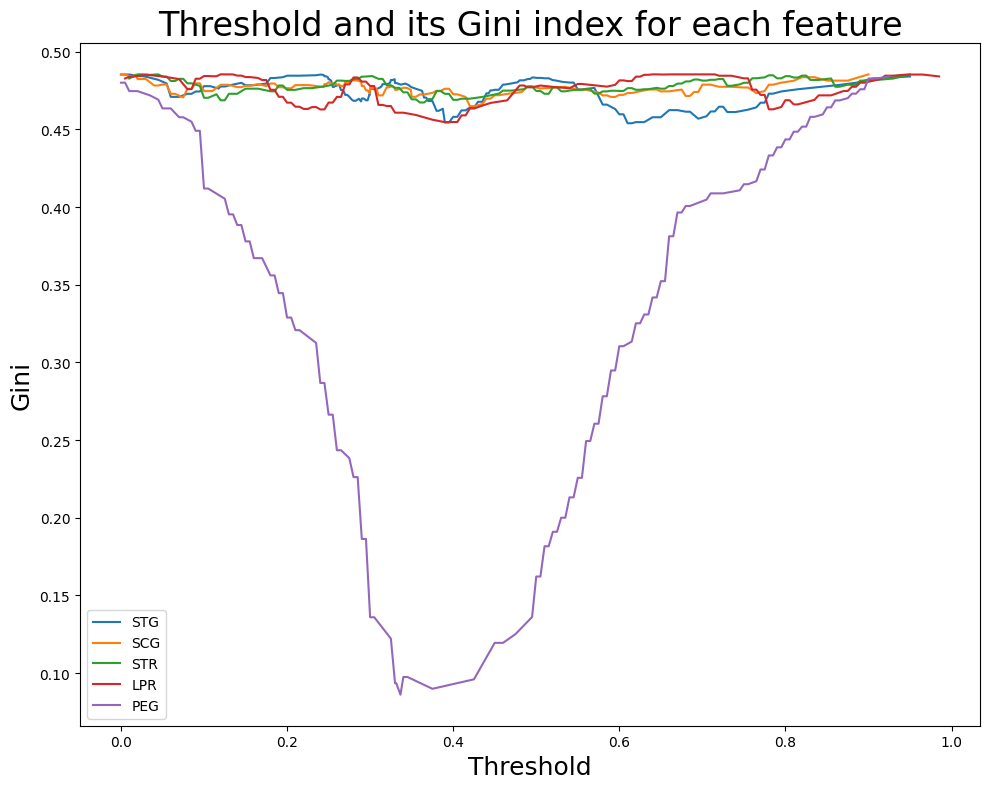

In [336]:
X = ['STG', 'SCG', 'STR', 'LPR', 'PEG']
y = df['UNS'].values

fig, ax = plt.subplots(figsize=(10, 8))

for column in X:
    feature_vector = df[column].values
    thresholds, gini_values, threshold_best, gini_best = find_best_split(feature_vector, y)
    ax.plot(thresholds, gini_values, label=column)

ax.set_xlabel('Threshold', fontsize=18)
ax.set_ylabel('Gini', fontsize=18)
ax.set_title('Threshold and its Gini index for each feature', fontsize=24)
ax.legend()

plt.tight_layout()
plt.show()

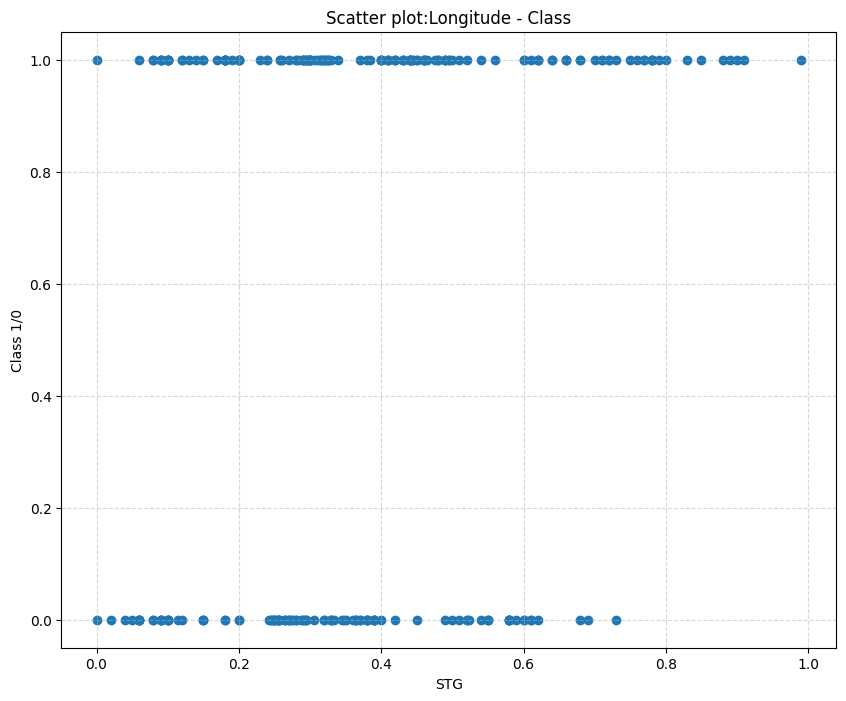

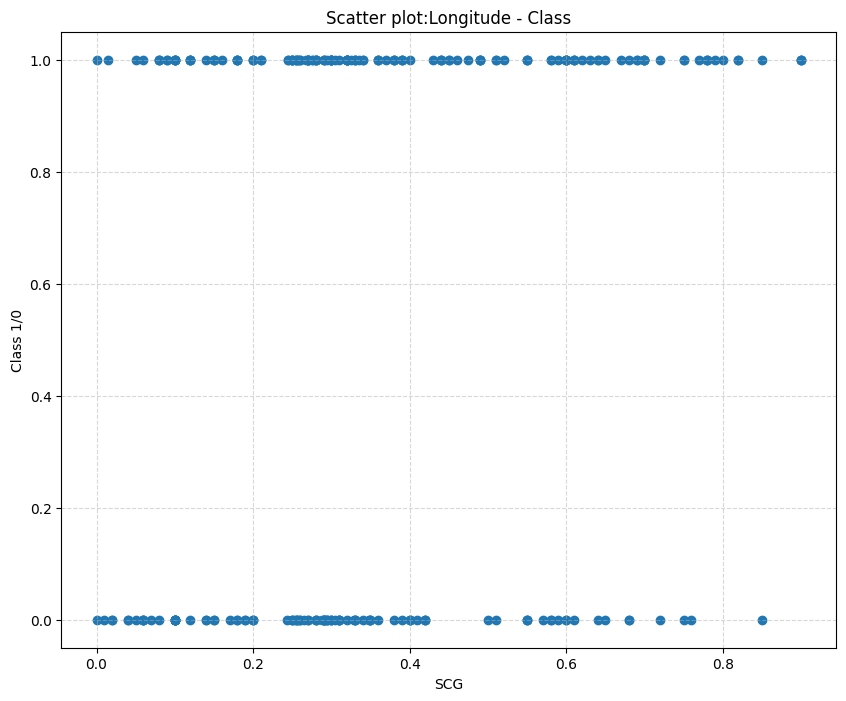

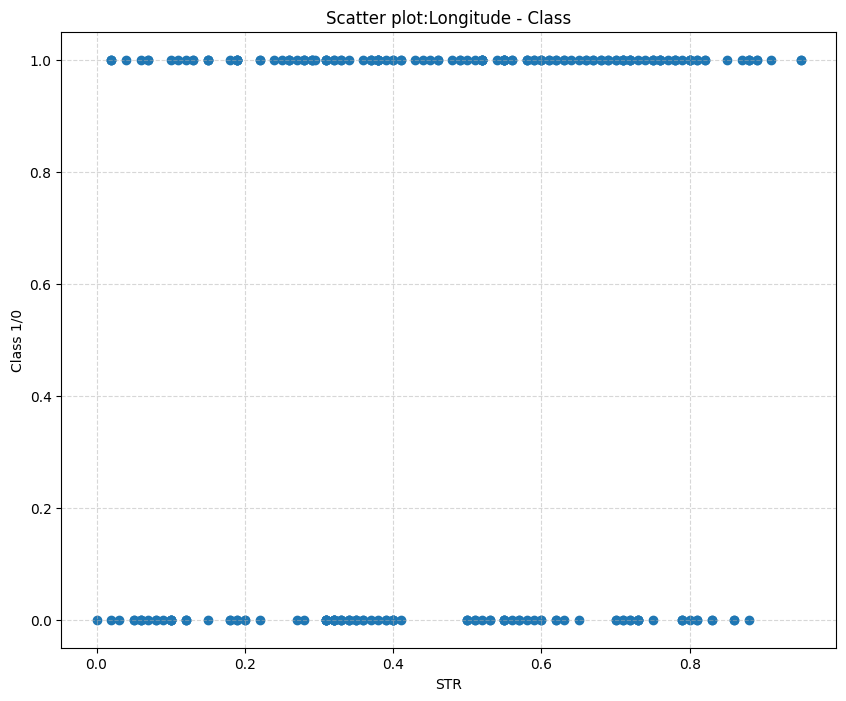

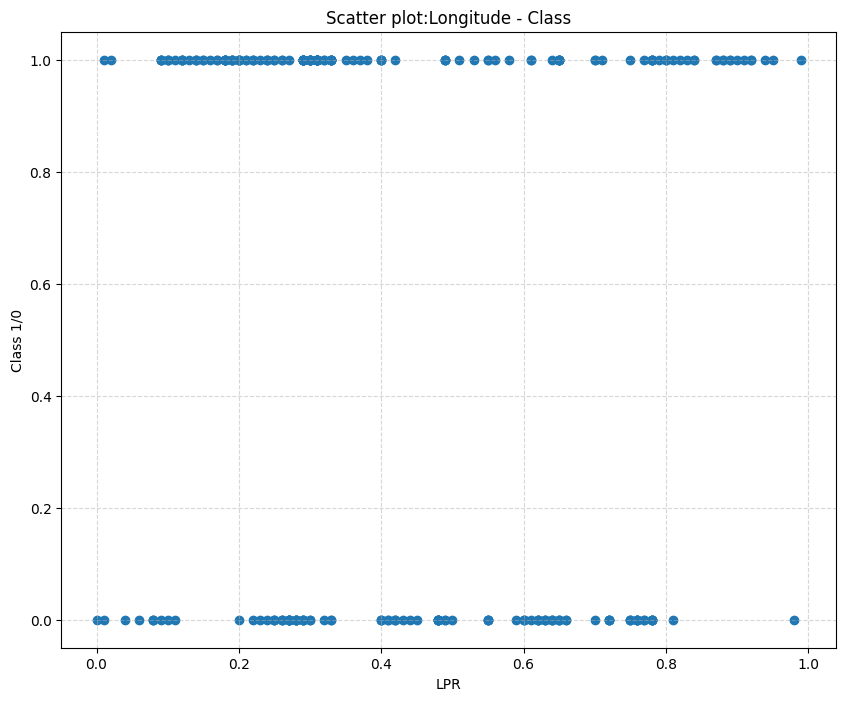

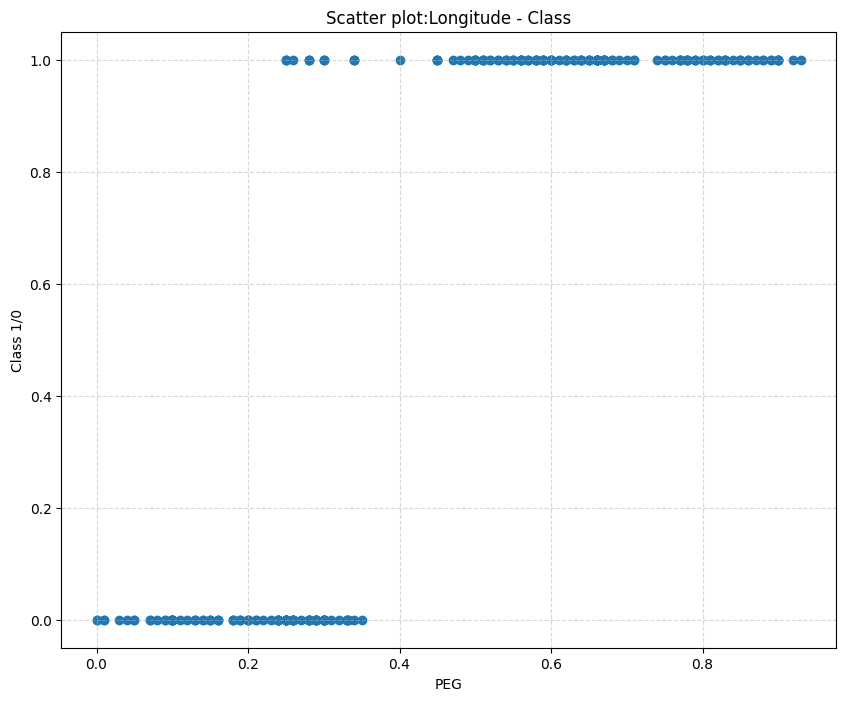

In [337]:
for column in X:
    plt.figure(figsize=(10, 8))
    plt.scatter(df[column], y)
    plt.xlabel(column)
    plt.ylabel('Class 1/0')
    title = "Scatter plot:" + feature + " - " + "Class"
    plt.title(title)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой диаграмм рассеяиния? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

In [94]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————

# PEG является лучшим выбором для разделения дерева на поддеревья, тк в таком случае критерий Gini является минимальным
# Да, с данными это согласуется, это хорошо видно на диаграммах распределения классов по фичам. Можно выбрать конкретное
# значение и помещать в левое поддерево, если оно меньше этого значения и наоборот.
# У хороших признаков кривая Gini имеет ступенчатый вид.
# Критерии Gini для признаков, по которым деление не возможно имеют вид прямой, а те которые подходят - ступечатый.
# Поэтому для плохих фич невозможно определить порог по которому можно разбивать дерево.

**Задание 2.4 (1 балл)** Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). 

1. Скачайте таблицу `agaricus-lepiota.data` (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), 
2. Считайте таблицу при помощи `pandas`,
3. Примените к каждому столбцу `LabelEncoder` (из `sklearn`), чтобы преобразовать строковые имена категорий в натуральные числа. 

Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

In [111]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [339]:
data = pd.read_csv(r'C:\Users\Oleg\Desktop\agaricus-lepiota.data', header=None)

In [340]:
X = data.iloc[:, 1:].values
y = data.iloc[:, 0].values

le = LabelEncoder()
X_encoded = np.zeros_like(X)
for i in range(X.shape[1]):
    X_encoded[:, i] = le.fit_transform(X[:, i])

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.5, random_state=6456356)

In [ ]:
dt = DecisionTree(feature_types=["categorical"] * X_encoded.shape[1])
dt.fit(X_train, y_train)

In [341]:
# У меня не получилось обучить дерево, как у многих в беседе ИАДа(бесконечное обучение), 
# тк find best split отрабатывает долго на этом датасете
# но мне не хочется терять балл, поэтому сделаю реализацию с использованием библиотеки sklearn

In [343]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

DecisionTreeClassifier()

In [345]:
y_pred = tree.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 1.0


## Часть 3: Бэггинг и случайный лес (4 балла)

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [346]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [348]:
data = pd.read_csv(r'C:\Users\Oleg\Desktop\diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

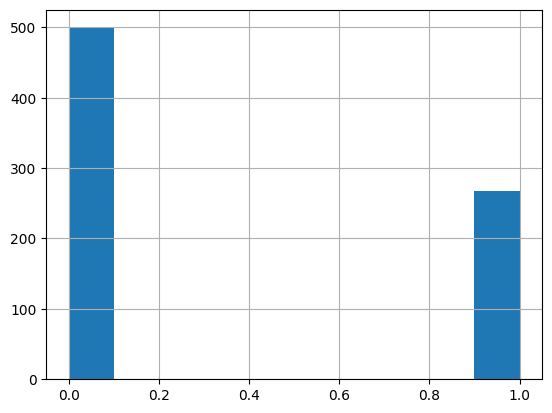

In [349]:
data['Outcome'].hist()
plt.show()

**Задание 3.1 (0.5 балла)** Разделите данные на признаки и целевую переменную. Разбейте датасет на обучающую и тестовую части в отношении 7:3. Затем разделите обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

In [353]:
feature_names = data.columns.drop('Outcome')
feature_names

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'],
      dtype='object')

In [370]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————

X = data[feature_names]
y = data["Outcome"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=6456356)
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, test_size=0.3, random_state=6456356)

**Задание 3.2 (1 балл)** На обучающей-валидационной выборке подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений обучите дерево на обучающей-обучающей выборке и определите качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберите ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке. 


Обучите решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [378]:
from sklearn.metrics import f1_score

max_depth = [2, 4, 6, 8, 10]
min_samples_leaf = [1, 2, 3, 4, 5]
best_f1_score = 0
best_max_depth = None
best_min_samples_leaf = None

for depth in max_depth:
    for leaf_samples in min_samples_leaf:
        model = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=leaf_samples)
        model.fit(X_train_train, y_train_train)
        y_pred_val = model.predict(X_train_val)
        f1 = f1_score(y_train_val, y_pred_val)
        if f1 > best_f1_score:
            best_f1_score = f1
            best_max_depth = depth
            best_min_samples_leaf = leaf_samples
print("best max depth:", best_max_depth)
print("best min sample leaf:", best_min_samples_leaf)
print("best f1:", best_f1_score)

best max depth: 10
best min sample leaf: 5
best f1: 0.6909090909090909


In [375]:
best_model = DecisionTreeClassifier(max_depth=best_max_depth, min_samples_leaf=best_min_samples_leaf)
best_model.fit(X_train, y_train)

y_pred_test = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)
auc_roc = roc_auc_score(y_test, y_pred_test)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("AUC-ROC:", auc_roc)

Accuracy: 0.7142857142857143
Precision: 0.6521739130434783
Recall: 0.5172413793103449
AUC-ROC: 0.6752873563218391


**Задание 3.3 (0.5 балла)** Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по тем же метрикам.

In [376]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
bagging_classifier = BaggingClassifier(n_estimators=50)
bagging_classifier.fit(X_train, y_train)

y_pred = bagging_classifier.predict(X_test)

In [377]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("AUC-ROC:", auc_roc) 
# значения на порядок лучше 

Accuracy: 0.7316017316017316
Precision: 0.6712328767123288
Recall: 0.5632183908045977
AUC-ROC: 0.6982758620689654


**Задание 3.4 (1 балл)** Выполните кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений проведите кросс-валидацию на полной обучающей выборке. Количество разбиений выберите на ваш вкус. В качестве критерия будем использовать `f1-меру`. Усредните значение критерия по всем прогонам кросс-валидации. 
3. Выберите ту пару значений, которая даёт наилучшее среднее качество. 

Обучите случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации по тем же метрикам. Какая из трёх построенных моделей показала себя лучше?

In [382]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
from sklearn.model_selection import cross_val_score

max_depth_parameters = [2, 3, 4, 5, 6, 7, 8]
min_samples_parameters = [2, 3, 4, 5, 6, 7]

best_f1_score = 0
best_max_depth = None
best_min_samples_split = None

for depth in max_depth_parameters:
    for split in min_samples_parameters:
        model = RandomForestClassifier(n_estimators=50, max_depth=depth, min_samples_split=split, random_state=12)
        f1_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1')
        mean_f1_score = f1_scores.mean()
        if mean_f1_score > best_f1_score:
            best_f1_score = mean_f1_score
            best_max_depth = depth
            best_min_samples_split = split
print("best max depth:", best_max_depth)
print("best min sample leaf:", best_min_samples_leaf)
print("best f1:", best_f1_score)

best max depth: 8
best min sample leaf: 5
best f1: 0.6316171575760616


In [414]:
best_model_rf = RandomForestClassifier(n_estimators=50, max_depth=best_max_depth, min_samples_split=best_min_samples_split, random_state=11)
best_model_rf.fit(X_train, y_train)

y_pred_test = best_model_rf.predict(X_test)

In [415]:
accuracy = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)
auc_roc = roc_auc_score(y_test, y_pred_test)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("AUC-ROC:", auc_roc) 

Accuracy: 0.7619047619047619
Precision: 0.7580645161290323
Recall: 0.5402298850574713
AUC-ROC: 0.7180316091954024


In [ ]:
# лучше всех показал себя рандом форест, его показатели оказались самыми высокими.

**Задание 3.5 (0.5 балла)** Постройте график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке. Какие выводы можно сделать?

In [409]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
n_estimators = [10, 20, 30, 40, 50, 60]
auc_roc = []
for n_estimator in n_estimators_values:
    rf = RandomForestClassifier(n_estimators = n_estimator, random_state = 11)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    auc_roc.append(roc_auc_score(y_test, y_pred))


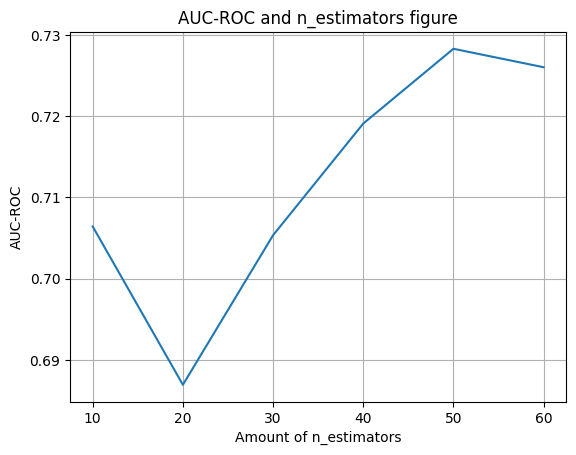

In [410]:
plt.figsize=(16, 10)
plt.plot(n_estimators, auc_roc)
plt.xlabel('Amount of n_estimators')
plt.ylabel('AUC-ROC')
plt.title('AUC-ROC and n_estimators figure')
plt.grid(True)
plt.show()

In [ ]:
# площадь aug roc для 50 деревьев в случайном лесу показывают наилучший результат среди остальных
# 60 тоже является не плохим значением судя по графику, но вот остальные приведут к низкому значению данной метрики

**Задание 3.6 (0.5 балла)** Для лучшей модели случайного леса из **Задания 3.4** посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

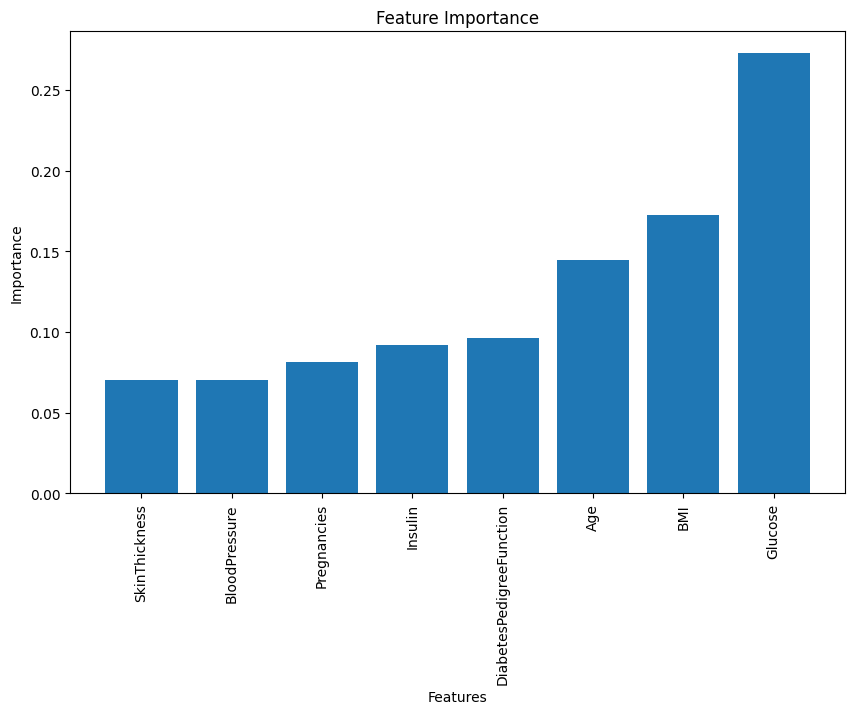

In [417]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
feature_importances = best_model_rf.feature_importances_
sorted_indices = feature_importances.argsort()

plt.figure(figsize=(10, 6))
plt.bar(feature_names[sorted_indices], feature_importances[sorted_indices])
plt.xticks(rotation='vertical')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()

In [ ]:
# Смотрим на р=график и делаем вывод, что Glucose (Глюкоза) 
# самый важный признак для определения диабета у пациента
# Другие признаки менее важны